# ARDL预测公共建筑电碳关系

导入数据

In [10]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as pdates
import warnings
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [11]:
data=pd.read_csv(".//data/Wholesale, Retail Trade and Catering Service.csv")
data.tail()

,Unnamed: 0,year,province,Electricity,coal and gas,Heat,CO2
685,685,2019,Liaoning,110.40,55.68,194.32,1.709605
686,686,2019,Chongqing,73.14,71.82,0.00,3.347195
687,687,2019,Shaanxi,93.91,100.55,890.58,3.925946
688,688,2019,Qinghai,12.41,27.57,118.08,1.649972
689,689,2019,Heilongjiang,53.30,529.84,4108.22,9.230348


## 输入要考察的省份

In [12]:
Provinces=data.province.drop_duplicates()

province=input("请输入省份(默认为北京)：" )or "Beijing"
while province not in Provinces.values:
    province=input("输入错误，请重新输入(默认为北京)：" )or "Beijing"

请输入省份(默认为北京)：


In [13]:
df=data[data.province==province]
df.index=df.year
df=df.drop(columns=['Unnamed: 0'])

In [14]:
df.tail()

,year,province,Electricity,coal and gas,Heat,CO2
year,,,,,,
2015,2015,Beijing,93.1700,78.290000,1353.880000,3.523065
2016,2016,Beijing,97.6806,72.991900,1248.408400,3.294925
2017,2017,Beijing,99.4894,63.270923,1245.772207,3.140578
2018,2018,Beijing,102.9000,32.040000,1274.020000,2.542527
2019,2019,Beijing,96.5100,29.750000,1206.890000,2.441161


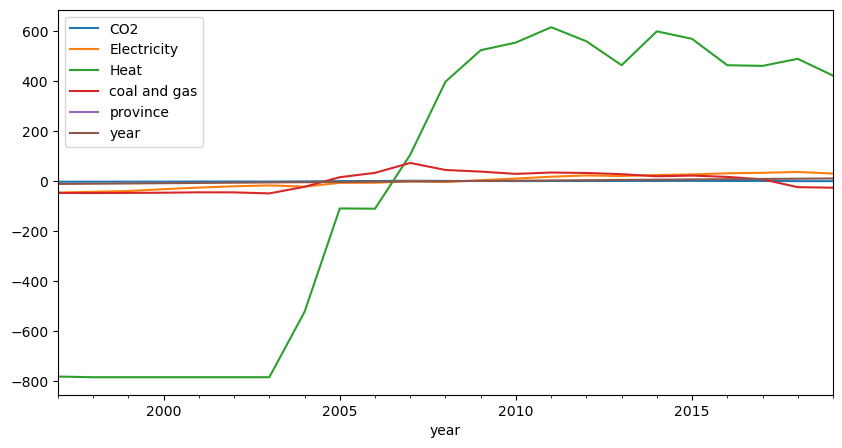

In [15]:
df.index=pd.to_datetime(df.year,format="%Y")
# df=df.drop(columns=['Unnamed:0','year','province'])
ax=(df-df.mean()).plot(figsize=(10,5))

In [16]:
test_num=5
train_set=df[0:-test_num]
test_set=df[-test_num:]
test_set.tail()

,year,province,Electricity,coal and gas,Heat,CO2
year,,,,,,
2015-01-01,2015,Beijing,93.1700,78.290000,1353.880000,3.523065
2016-01-01,2016,Beijing,97.6806,72.991900,1248.408400,3.294925
2017-01-01,2017,Beijing,99.4894,63.270923,1245.772207,3.140578
2018-01-01,2018,Beijing,102.9000,32.040000,1274.020000,2.542527
2019-01-01,2019,Beijing,96.5100,29.750000,1206.890000,2.441161


In [17]:
def Find_opt_trend(train_set):
    trend_option=['n','c','t','ct']
    for trend in trend_option:
        res_sol=ardl_select_order(train_set.CO2,0,train_set[['Electricity','coal and gas','Heat']],1,ic='aic',trend=trend)
        res=res_sol.model.fit()
        if 'AIC' not in vars():
            AIC=res.aic
            opt_trend=trend
        else:
            if res.aic<AIC:
                opt_trend=trend
    return opt_trend                

In [22]:
%%time
for province in Provinces:
    df=data[data.province==province]
    df.index=df.year
    df=df.drop(columns=['Unnamed: 0'])
    df.index=pd.to_datetime(df.year,format="%Y")
#     test_num=4
#     train_set=df[0:-test_num]
#     test_set=df[-test_num:]
    trend=Find_opt_trend(df)
#     res_sol=ardl_select_order(train_set.CO2,0,train_set[['Electricity','coal and gas','Heat']],0,ic='aic',trend=trend)
#     res=res_sol.model.fit()
#     predict=res.get_prediction(start=len(df)-test_num,end=len(df)-1,exog_oos=test_set[['Electricity','coal and gas','Heat']])
#     predict_value=pd.Series(predict.predicted_mean.values,index=test_set.index)
#     err=np.mean(np.abs(predict_value-test_set.CO2)/test_set.CO2)*100
    res_sol=ardl_select_order(df.CO2,0,df[['Electricity','coal and gas','Heat']],0,ic='aic',trend=trend)
    res=res_sol.model.fit()
    model = sm.OLS(df.CO2, sm.add_constant(df[['Electricity', 'coal and gas', 'Heat']])).fit()
    r_squared = model.rsquared
#     predict=model.get_prediction(start=0,end=len(df)-1,exog_oos=df[['Electricity','coal and gas','Heat']])
    predict=model.get_prediction(sm.add_constant(df[['Electricity', 'coal and gas', 'Heat']]))
    predict_value=pd.Series(predict.predicted_mean,index=df.index)
    predict_conf_int=predict.conf_int()
    err=np.mean(np.abs((predict_value-df.CO2)/(predict_value+df.CO2)/2))*100
    fig,ax=plt.subplots(figsize=(10,5))
    fig.suptitle(province+" SMAPE="+format(err,'.3f')+"%")
    ax.plot(df.index,df.CO2,label='real')
    ax.plot(df.index,predict_value.values,label='predicted')
    ax.fill_between(df.index,predict_conf_int[:,0],predict_conf_int[:,1],alpha=0.3,color='grey',label="95% Conf int")
    ax.legend(loc='best')
    filename=".\\figure\\" +province+"_R^2="+format(r_squared,'.3f')+".png"
    plt.savefig(filename,dpi=150)
    plt.close()
    print(province,"的SMAPE为%.3f"% err,"%\n")
    print(res_sol.model.ardl_order)

Shanghai 的SMAPE为1.222 %

(0, 0, 0, 0)
Yunnan 的SMAPE为1.988 %

(0, 0, 0, 0)
InnerMongolia 的SMAPE为5.274 %

(0, 0, 0, 0)
Beijing 的SMAPE为1.570 %

(0, 0, 0)
Jilin 的SMAPE为1.983 %

(0, 0, 0, 0)
Sichuan 的SMAPE为1.443 %

(0, 0, 0)
Tianjin 的SMAPE为2.590 %

(0, 0, 0, 0)
Ningxia 的SMAPE为13.314 %

(0, 0, 0)
Anhui 的SMAPE为2.141 %

(0, 0, 0)
Shandong 的SMAPE为2.603 %

(0, 0, 0, 0)
Shanxi 的SMAPE为2.762 %

(0, 0, 0, 0)
Guangdong 的SMAPE为2.037 %

(0, 0)
Guangxi 的SMAPE为0.976 %

(0, 0, 0)
Xinjiang 的SMAPE为2.626 %

(0, 0, 0)
Jiangsu 的SMAPE为5.010 %

(0, 0, 0)
Jiangxi 的SMAPE为6.149 %

(0, 0)
Hebei 的SMAPE为2.608 %

(0, 0, 0, 0)
Henan 的SMAPE为6.195 %

(0, 0)
Zhejiang 的SMAPE为0.924 %

(0, 0, 0)
Hainan 的SMAPE为5.598 %

(0, 0)
Hubei 的SMAPE为2.567 %

(0, 0, 0)
Hunan 的SMAPE为4.433 %

(0, 0, 0)
Gansu 的SMAPE为1.164 %

(0, 0, 0)
Fujian 的SMAPE为1.549 %

(0, 0, 0)
Guizhou 的SMAPE为1.161 %

(0, 0, 0)
Liaoning 的SMAPE为3.450 %

(0, 0, 0)
Chongqing 的SMAPE为3.884 %

(0, 0)
Shaanxi 的SMAPE为5.369 %

(0, 0)
Qinghai 的SMAPE为5.596 %

(0, 0, 0)
Heilongjia

In [9]:
trend=Find_opt_trend(train_set)
res_sol=ardl_select_order(train_set.CO2,0,train_set[['Electricity','coal and gas','Heat']],0,ic='aic',trend=trend)
print(res_sol.model.ardl_order)

(0, 0, 0)


In [10]:
res=res_sol.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                    CO2   No. Observations:                   18
Model:                  ARDL(0, 0, 0)   Log Likelihood                  14.152
Method:               Conditional MLE   S.D. of innovations              0.110
Date:                Thu, 11 May 2023   AIC                            -18.303
Time:                        19:58:37   BIC                            -13.851
Sample:                    01-01-1997   HQIC                           -17.689
                         - 01-01-2014                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1019      0.091     -1.120      0.282      -0.297       0.093
trend               0.1210      0.017      7.018      0.000       0.084       0.158
coal and gas.L0     0.0279      0.002     17.314      0.000       0.024       0.031
Heat.L0            -0.0008      0.000     -3.902      0.002      -0.001      -0.000
===================================================================================
"""

In [11]:
res.aic

-18.303047735712806

In [12]:
predict=res.get_prediction(start=len(df)-test_num,end=len(df)-1,exog_oos=test_set[['Electricity','coal and gas','Heat']])
predict_value=pd.Series(predict.predicted_mean.values,index=test_set.index)
err=np.mean(np.abs(predict_value-test_set.CO2)/test_set.CO2)*100
predict_conf_int=predict.conf_int()
print(province,"的平均预测误差为%.3f"% err,"%\n")

Beijing 的平均预测误差为4.107 %



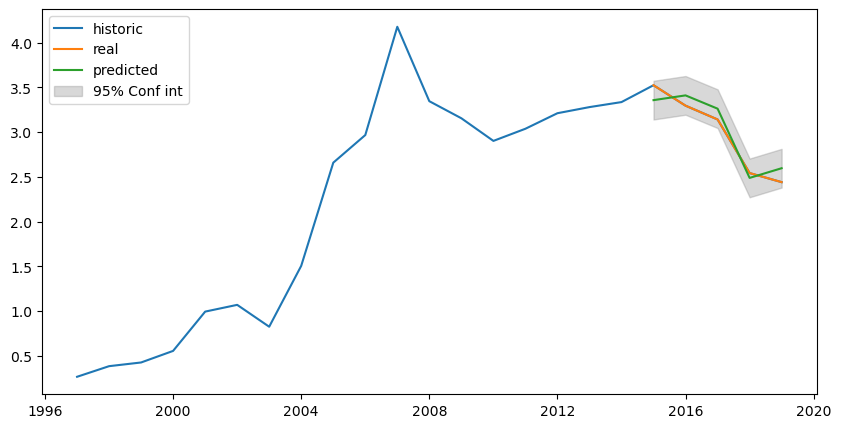

In [13]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(df.index,df.CO2,label='historic')
ax.plot(test_set.index,test_set.CO2,label='real')
ax.plot(predict_value.index,predict_value.values,label='predicted')
ax.fill_between(predict_conf_int.index,predict_conf_int['lower'],predict_conf_int['upper'],alpha=0.3,color='grey',label="95% Conf int")
ax.legend(loc='best')
plt.show()

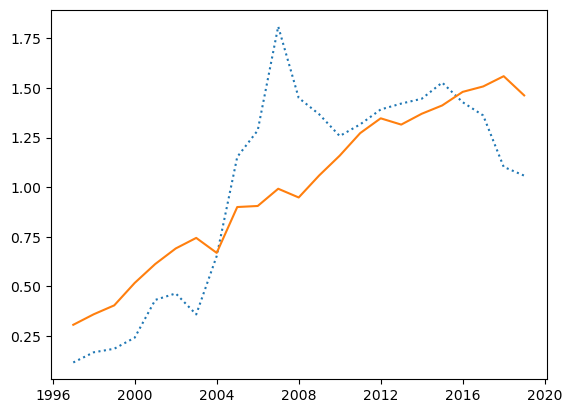

In [14]:
plt.plot(df.index,df.CO2/df.CO2.mean(),':',df.index,df.Electricity/df.Electricity.mean())

In [89]:
MASE=np.mean(np.abs(df.CO2-predict_value))/np.abs(df.CO2.diff(1).dropna().mean())
MAE=np.mean(np.abs(np.abs(df.CO2-predict_value))/df.CO2)
MAE

0.17126422263405675